In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf


# Data preprocessing
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_squared_log_error

# Neural net model
import keras
from keras import Input
from tensorflow.keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping

# **1. XỬ LÝ DATASET**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/predicting-house-prices/dataset/housing.csv')

In [3]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
df.shape  # 2D

(20640, 10)

# **#. DỮ LIỆU TRỐNG**

In [5]:
df.isnull().sum()   # null

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [6]:
median_value = df['total_bedrooms'].median() # trung vị
df['total_bedrooms'] = df['total_bedrooms'].fillna(median_value)

In [7]:
df.isnull().sum()   # null

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


# **#. ENCODING**
-mã hóa non-numeric sang numeric

In [8]:
df.info()  # kiểm tra numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
df['ocean_proximity'].value_counts() # xác định loại encoder

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [10]:
df['ocean_proximity'].values.reshape(-1,1)  # chuyển sang cấu trúc của 1 batch: shape(n_row, 1_column)

array([['NEAR BAY'],
       ['NEAR BAY'],
       ['NEAR BAY'],
       ...,
       ['INLAND'],
       ['INLAND'],
       ['INLAND']], dtype=object)

In [11]:
ocp_series = df['ocean_proximity'].values  # series
ocp_series.shape  # 1D

(20640,)

In [12]:
# np.array(df[['ocean_proximity']]) # chuyển df sang mảng
ocp_df = ocp_series.reshape(-1,1)  # chuyển series sang array 2D: (row, column)
ocp_df.shape  # 2D

(20640, 1)

In [13]:
onehot_encoder = OneHotEncoder(sparse_output=False) # encoding nhị phân

ocp_encoded = onehot_encoder.fit_transform(ocp_df) # fit và transform

ocp_encoded_df = pd.DataFrame(ocp_encoded, columns=onehot_encoder.get_feature_names_out(['ocean_proximity'])) # tạo dataframe

df = pd.concat([df.drop('ocean_proximity', axis=1), ocp_encoded_df], axis=1) # nối dataframe


In [14]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0


# **#. SPLIT DATASET**

In [15]:
F = df.drop('median_house_value', axis=1)
F.shape  # 2D: (row, column)

(20640, 13)

In [16]:
F.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0.0,0.0,0.0,1.0,0.0


In [17]:
y = df["median_house_value"]
y.shape  # 1D: (row,)

(20640,)

In [18]:
y.head()

,median_house_value
0,452600.0
1,358500.0
2,352100.0
3,341300.0
4,342200.0


In [19]:
F_train, F_remain, y_train, y_remain = train_test_split(F, y, test_size=0.2, random_state=123)  # 80% train, 20% remain

In [20]:
remain_length = len(F_remain)
remain_length

4128

In [21]:
test_length = math.floor(20640*0.05)   # 5% test
test_length

1032

In [22]:
test_ratio = test_length/remain_length  # tỉ lệ của test trong remain
F_val, F_test, y_val, y_test = train_test_split(F_remain, y_remain, test_size=test_ratio, random_state=123)

In [23]:
print("F_train shape:", F_train.shape)  # 2D
print("F_val shape:", F_val.shape)
print("F_test shape:", F_test.shape)

print("y_train shape:", y_train.shape)  # 1D
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

F_train shape: (16512, 13)
F_val shape: (3096, 13)
F_test shape: (1032, 13)
y_train shape: (16512,)
y_val shape: (3096,)
y_test shape: (1032,)


In [24]:
# 1D thành 2D
y_train = y_train.values.reshape(-1,1) # shape(n_row, 1_column)
y_val = y_val.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("y_train shape:", y_train.shape)   # 2D: (row, column)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16512, 1)
y_val shape: (3096, 1)
y_test shape: (1032, 1)


In [25]:
# mảng
F_train = np.array(F_train) # 2D
F_val = np.array(F_val)
F_test = np.array(F_test)

y_train = np.array(y_train)  # 2D
y_val = np.array(y_val)
y_test = np.array(y_test)

y_train

array([[287500.],
       [271500.],
       [191700.],
       ...,
       [286200.],
       [412500.],
       [ 59300.]])

# **#. SCALING**
-chỉ chuẩn hóa sau khi đã chia dataset

-tính min, max trong từng cột và chia tỉ lệ (chuẩn hóa về [0, 1])

In [26]:
scaler_F = MinMaxScaler()
F_train = scaler_F.fit_transform(F_train)  # fit và transform
F_val = scaler_F.transform(F_val)     # transform
F_test = scaler_F.transform(F_test)   # transform

# tùy chọn
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

print(F_train[:2], f"\n")
print(y_train[:2])

[[0.20119522 0.62061637 0.52941176 0.02589145 0.02607076 0.01754017
  0.0268048  0.2806513  0.         1.         0.         0.
  0.        ]
 [0.57270916 0.18278427 0.33333333 0.15646778 0.16589075 0.10527606
  0.16987338 0.35442959 1.         0.         0.         0.
  0.        ]] 

[[0.56185542]
 [0.52886586]]


# **2. MODEL**

In [27]:
#kiến trúc model

model = Sequential()

model.add(Input(shape=(F_train.shape[1],)))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

# output-layer: 1 neuron, không activation (vì hồi quy)
model.add(Dense(1))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 45,697 (178.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [28]:
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

history = model.fit(F_train, y_train,
                    validation_data=(F_val, y_val),
                    epochs=500,
                    batch_size=250,
                    callbacks=[early_stop], verbose=1)

Epoch 1/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5744 - mae: 0.5378 - val_loss: 0.0544 - val_mae: 0.1582
Epoch 2/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0469 - mae: 0.1657 - val_loss: 0.0408 - val_mae: 0.1473
Epoch 3/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0365 - mae: 0.1457 - val_loss: 0.0419 - val_mae: 0.1595
Epoch 4/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0338 - mae: 0.1402 - val_loss: 0.0424 - val_mae: 0.1546
Epoch 5/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0303 - mae: 0.1285 - val_loss: 0.0460 - val_mae: 0.1693
Epoch 6/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0274 - mae: 0.1224 - val_loss: 0.0372 - val_mae: 0.1534
Epoch 7/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0256 - mae: 0.1186 - val_loss: 0.0340 - val_mae: 0.1436
Epoch 8/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0260 - mae: 0.1197 - val_loss: 0.0244 - val_mae: 0.1200
Epoch 9/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

# **3. ĐÁNH GIÁ MODEL**

In [29]:
# đánh giá model trên tập test

y_pred_test = model.predict(F_test)  # test-dataset ko chia batch (chạy 1 lần)

print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("MSLE:", mean_squared_log_error(y_test, y_pred_test))
print("score :", r2_score(y_test, y_pred_test))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 0.06651573255305382
MSE: 0.009985046911148732
MSLE: 0.004422154750828562
score : 0.8310255279347436


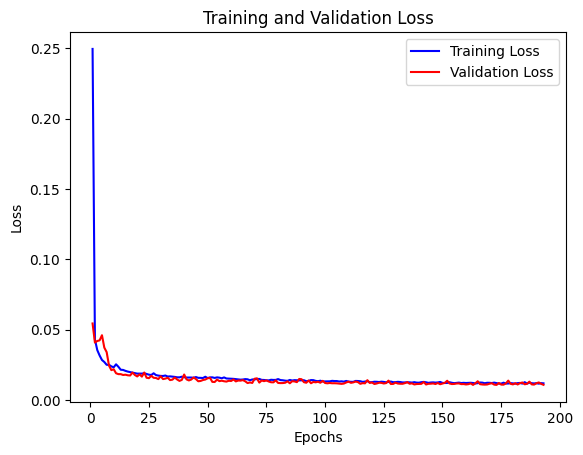

In [30]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


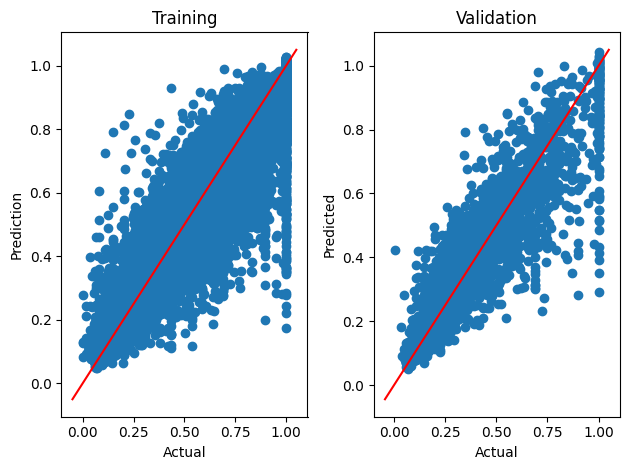

In [31]:
# Specify the dimensions
fig, axes = plt.subplots(1,2)

# This makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(F_train))
axes[0].set_xlabel('Actual', fontsize=10)
axes[0].set_ylabel('Prediction', fontsize=10)
axes[0].set_title('Training')

# Add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_val, y=model.predict(F_val))
axes[1].set_xlabel('Actual', fontsize=10)
axes[1].set_ylabel('Predicted', fontsize=10)
axes[1].set_title('Validation')

# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# Tight layout
fig.tight_layout()
plt.show()

# **4. DỰ ĐOÁN**

In [32]:
def prepare_input(longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity):
    # encoding
    ocp_encoded = onehot_encoder.transform(np.array([[ocean_proximity]])) # (1, 5)

    features_remain = np.array([[longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income]]) # (1, 8)

    # nối mảng
    F_predict = np.concatenate((features_remain, ocp_encoded), axis=1)  # (1, 13)

    # scaling
    F_predict = scaler_F.transform(F_predict)

    return F_predict

In [33]:
#92300.0
input = {
    "longitude": -121.22,
    "latitude": 39.43,
    "housing_median_age": 17.0,
    "total_rooms": 2254.0,
    "total_bedrooms": 485.0,
    "population": 1007.0,
    "households": 433.0,
    "median_income": 1.7000,
    "ocean_proximity": "INLAND"
}

F_pred1 = prepare_input(**input)
y_pred1 = model.predict(F_pred1)
y_pred1 = scaler_y.inverse_transform(y_pred1)
y_pred1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[97540.17]], dtype=float32)

In [34]:
#342200.0
input = {
    "longitude": -122.25,
    "latitude": 37.85,
    "housing_median_age": 52.0,
    "total_rooms": 1627.0,
    "total_bedrooms": 280.0,
    "population": 565.0,
    "households": 259.0,
    "median_income": 3.8462,
    "ocean_proximity": "NEAR BAY"
}

F_pred2 = prepare_input(**input)
y_pred2 = model.predict(F_pred2)
y_pred2 = scaler_y.inverse_transform(y_pred2)
y_pred2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[233717.69]], dtype=float32)

In [35]:
#452600.0000
input = {
    "longitude": -122.2300,
    "latitude": 37.8800,
    "housing_median_age": 41.0000,
    "total_rooms": 880.0000,
    "total_bedrooms": 129.0000,
    "population": 322.0000,
    "households": 126.0000,
    "median_income": 8.3252,
    "ocean_proximity": "ISLAND"
}

F_pred3 = prepare_input(**input)
y_pred3 = model.predict(F_pred3)
y_pred3 = scaler_y.inverse_transform(y_pred3)
y_pred3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[383272.88]], dtype=float32)

# **5. SAVE MODEL**

In [36]:
import pickle

pickle_dir_path="/content/drive/MyDrive/Colab Notebooks/predicting-house-prices/model"

with open(f'{pickle_dir_path}/onehot_encoder.pkl', 'wb') as f1:
    pickle.dump(onehot_encoder, f1)

with open(f'{pickle_dir_path}/scaler_F.pkl', 'wb') as f2:
    pickle.dump(scaler_F, f2)

with open(f'{pickle_dir_path}/scaler_y.pkl', 'wb') as f3:
    pickle.dump(scaler_y, f3)

model.save(f"{pickle_dir_path}/model.h5")

In [37]:
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

scikit-learn version: 1.6.1
TensorFlow version: 2.18.0
Keras version: 3.8.0
